In [18]:
import numpy as np
import scipy
import random
import pandas as pd
import pickle
import seaborn.objects as so
import hashlib
import matplotlib.pyplot as plt


import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats   

In [68]:
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [1146]:
%%scalene --profile-all --cli

def tester(x):
    c = 0
    for i in range(x):
        for j in range(10000):
            c += 1

tester(100)

                                      [1146]: % of time = 100.00% (50.321ms) out of 50.321ms.                                      
       ╷       ╷       ╷       ╷       ╷                                                                                           
       │Time   │–––––– │–––––– │–––––– │                                                                                           
  Line │Python │native │system │GPU    │[1146]                                                                                     
╺━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸
     1 │       │       │       │       │%%scalene --profile-all --cli                                                              
     2 │       │       │       │       │                                                                                           
     3 │       │       │       │       │def tester(x):                      

In [63]:
import glob


with open("Metrics_Folder/Metrics_32.pickle", 'rb') as handle:
    metrics = pickle.load(handle)

In [975]:
#with open(f'Metrics_Folder/Metrics_{18}.pickle', 'wb') as handle:
#    pickle.dump(metrics[:18], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
df_runs = pd.DataFrame(metrics).drop(["expert metrics", "verma", "hemmer"], axis=1)
df_runs

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",0,4,8,32,"(0, 0)",5,PERFECT,perfect,target,False
1,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,False
2,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,True
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
5,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,False
6,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,True
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
9,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,False


In [65]:
class MetricManager:
    def __init__(self, metrics):
        self.metrics = metrics

        self.metrics_dfs = {
            "verma": {},
            "hemmer": {}
        }

    def create_dataframe_one_metric(self, run, method, seed, fold, step):
        if method == "verma":
            return self.create_dataframe_verma(run, seed, fold, step)
        if method == "hemmer":
            return self.create_dataframe_hemmer(run, seed, fold, step)

    def create_dataframe_verma(self, run, seed, fold, step):
        df = pd.DataFrame(self.metrics[run]["verma"][seed][fold][step]).drop(["acc_experts", "cov_experts"], axis=0).T
        df["coverage"] = df["coverage"].apply(lambda x: getCountOfCoverage(x))
        df.rename(columns={'coverage':'n_images'}, inplace=True)
        return df

    def create_dataframe_hemmer(self, run, seed, fold, step):
        df = pd.DataFrame(self.metrics[run]["hemmer"][seed][fold]["train"]).T
        n_images = getCountOfCoverage(self.metrics[run]["verma"][seed][fold]["train"][0]["coverage"])
        experts = [column[7:] for column in df.columns if "Expert" in column]
        df["Classifier Coverage"] = n_images * df["Classifier Coverage"]
        for expert in experts:
            df[f"{expert} Accuracy"] = [row["expert_accuracy"] for row in df[f"Expert_{expert}"]]
            df[f"{expert} Subset Accuracy"] = [row["expert_task_subset_accuracy"] for row in df[f"Expert_{expert}"]]
            df[f"{expert} Coverage"] = [n_images * row["expert_coverage"] for row in df[f"Expert_{expert}"]]
            df = df.drop([f"Expert_{expert}"], axis=1)
        return df

    def create_l2d_dataframe(self, metric, method, step):
        dict_run = {}
        for run in range(len(metrics)):
            dict_seed = {}
            for seed, val1 in self.metrics[run][method].items():
                dict_fold = {}
                for fold, element in self.metrics[run][method][seed].items():
                    dict_fold[f"Fold_{fold}"] = self.create_dataframe_one_metric(run, method, seed, fold, step)
                df_seed = pd.concat(dict_fold)
                dict_seed[f"Seed_{seed}"] = df_seed
            df_run = pd.concat(dict_seed)
            dict_run[f"Run_{run}"] = df_run
        df_test = pd.concat(dict_run)
        return df_test

    def create_metric_dataframe(self, df, metric_name, method):
        dff = df[[metric_name]]
        index = dff.index
        index_runs = index.get_level_values(0).drop_duplicates()
        index_seeds = index.get_level_values(1).drop_duplicates()
        index_folds = index.get_level_values(2).drop_duplicates()

        values = {}
        for run in index_runs:
            run_list = []
            for seed in index_seeds:
                for fold in index_folds:
                    if method == "max":
                        run_list.append(dff.loc[(run, seed, fold)].max()[0])
                    if method == "var":
                        run_list.append(dff.loc[(run, seed, fold)].var()[0])
            values[run] = run_list
        return pd.DataFrame(values)

    def get_metric_df(self, method, step):
        if step not in self.metrics_dfs[method]:
            self.metrics_dfs[method][step] = self.create_l2d_dataframe(self.metrics, method, step)
        return self.metrics_dfs[method][step]

    def get_metric_dataframe(self, method, step, metric_name, apply_method):
        return self.create_metric_dataframe(self.get_metric_df(method, step), metric_name, apply_method)

    def print_metrics(self, df):
        print(df.columns)

    def get_ttest(self, value1, value2, equal_var=True):
        res = ttest_ind(value1, value2, equal_var=equal_var)
        return res

def check_all_ttest(df, p=0.05, equal_var=False):
    matrix = {}
    for i in df.columns:
        row = {}
        for j in df.columns:
            if i == j:
                row[j] = 1
            else:
                res = get_ttest(df.loc[:,[i]], df.loc[:,[j]], equal_var=equal_var)
                row[j] = res.pvalue[0]
        matrix[i] = row
    return matrix

def get_ttest(value1, value2, equal_var=True):
    res = ttest_ind(value1, value2, equal_var=equal_var)
    #print(res)
    return res

def getCountOfCoverage(text):
    marker = None
    for j in range(len(text)):
        if text[-j] == "f":
            marker = j -1
    return int(text[-marker:])

def cut_column_name(df):
    columns = [column[4:] for column in df.columns]
    df.columns = columns
    return df
        

metricManager = MetricManager(metrics)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



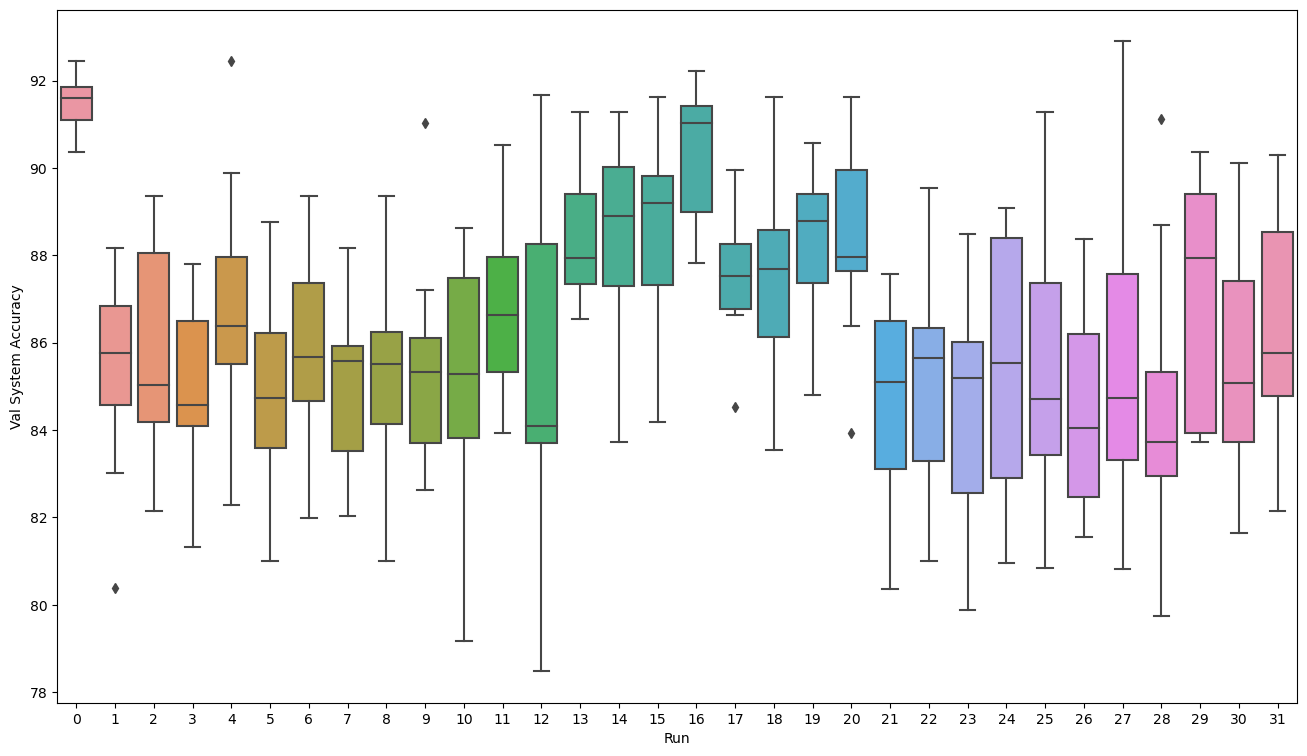

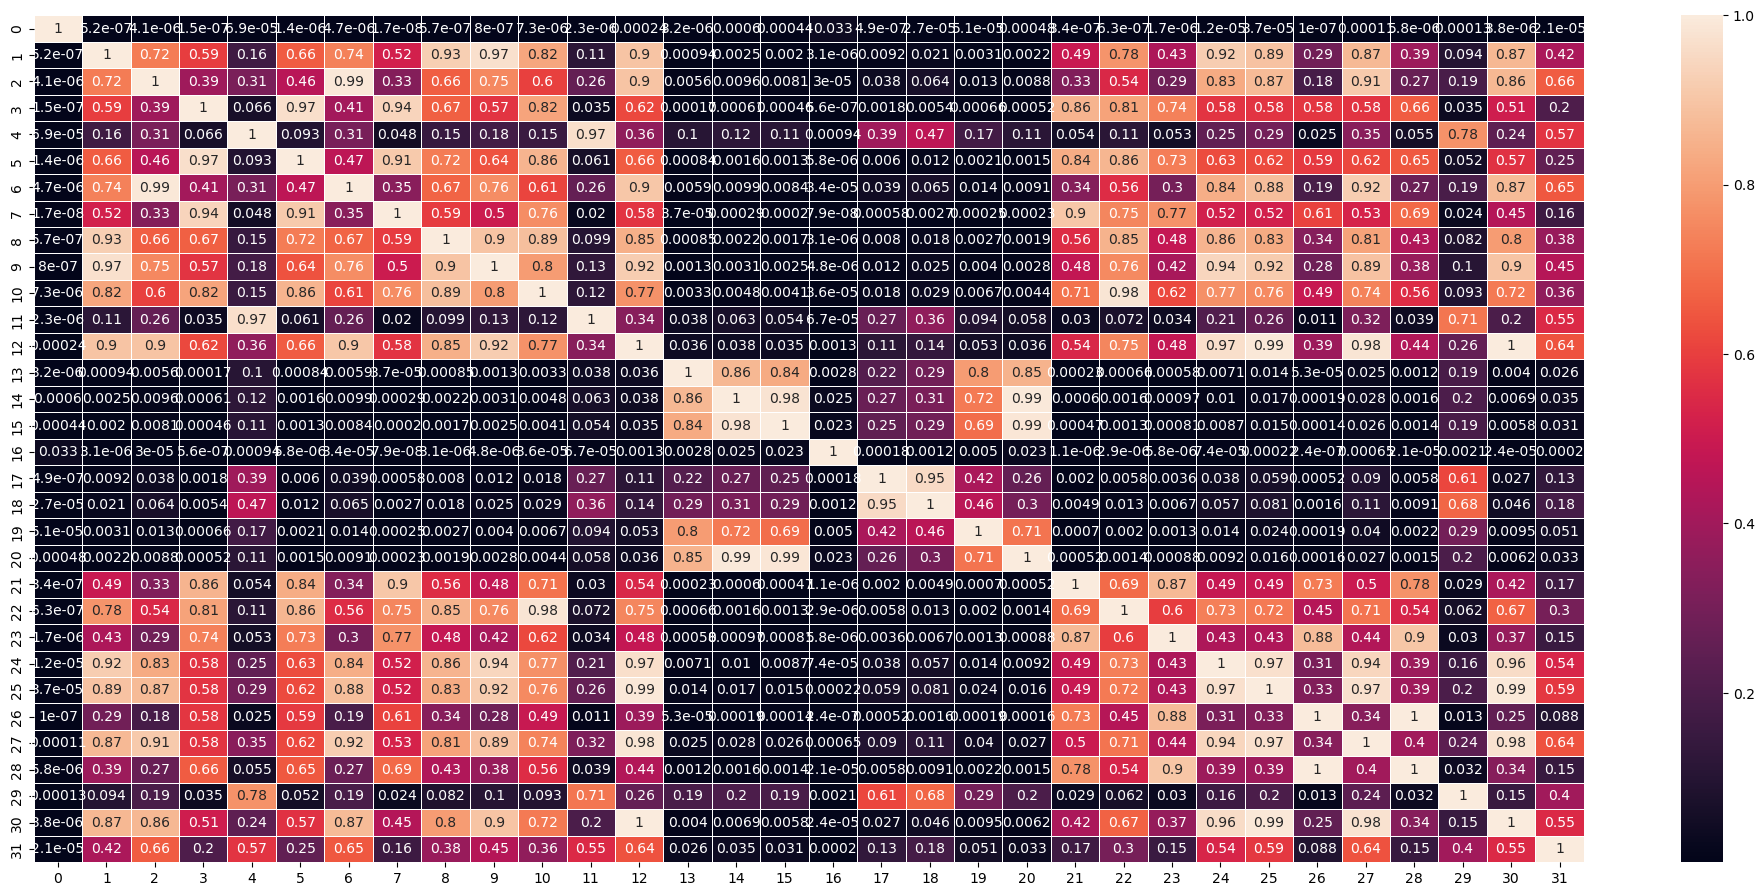

In [69]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "system_accuracy", "max"))#.T.iloc[[1, 2, 3, 4, 25, 26, 27, 28]].T
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Val System Accuracy')
sns.boxplot(df_accuracy)

df_ttests = pd.DataFrame(check_all_ttest(df_accuracy))
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 11))
sns.heatmap(df_ttests, annot=True, linewidths=.5, ax=ax)

<Axes: >

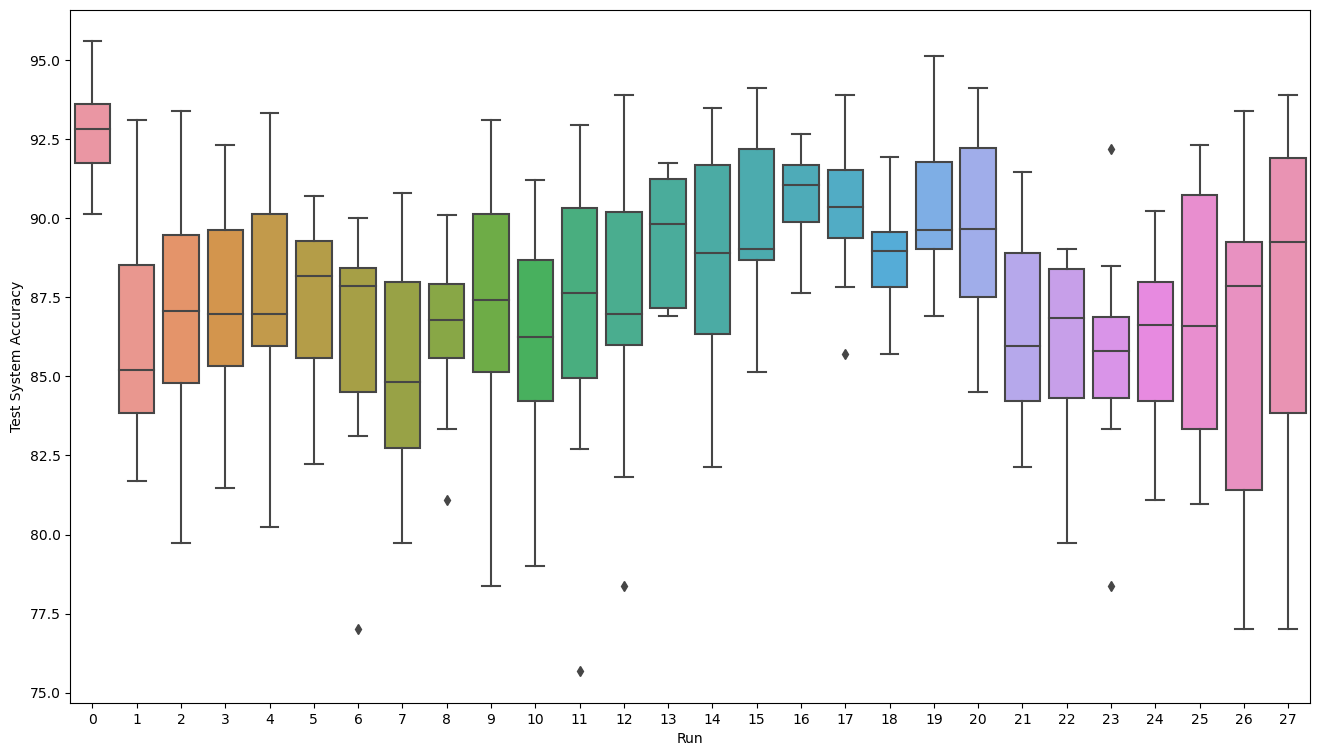

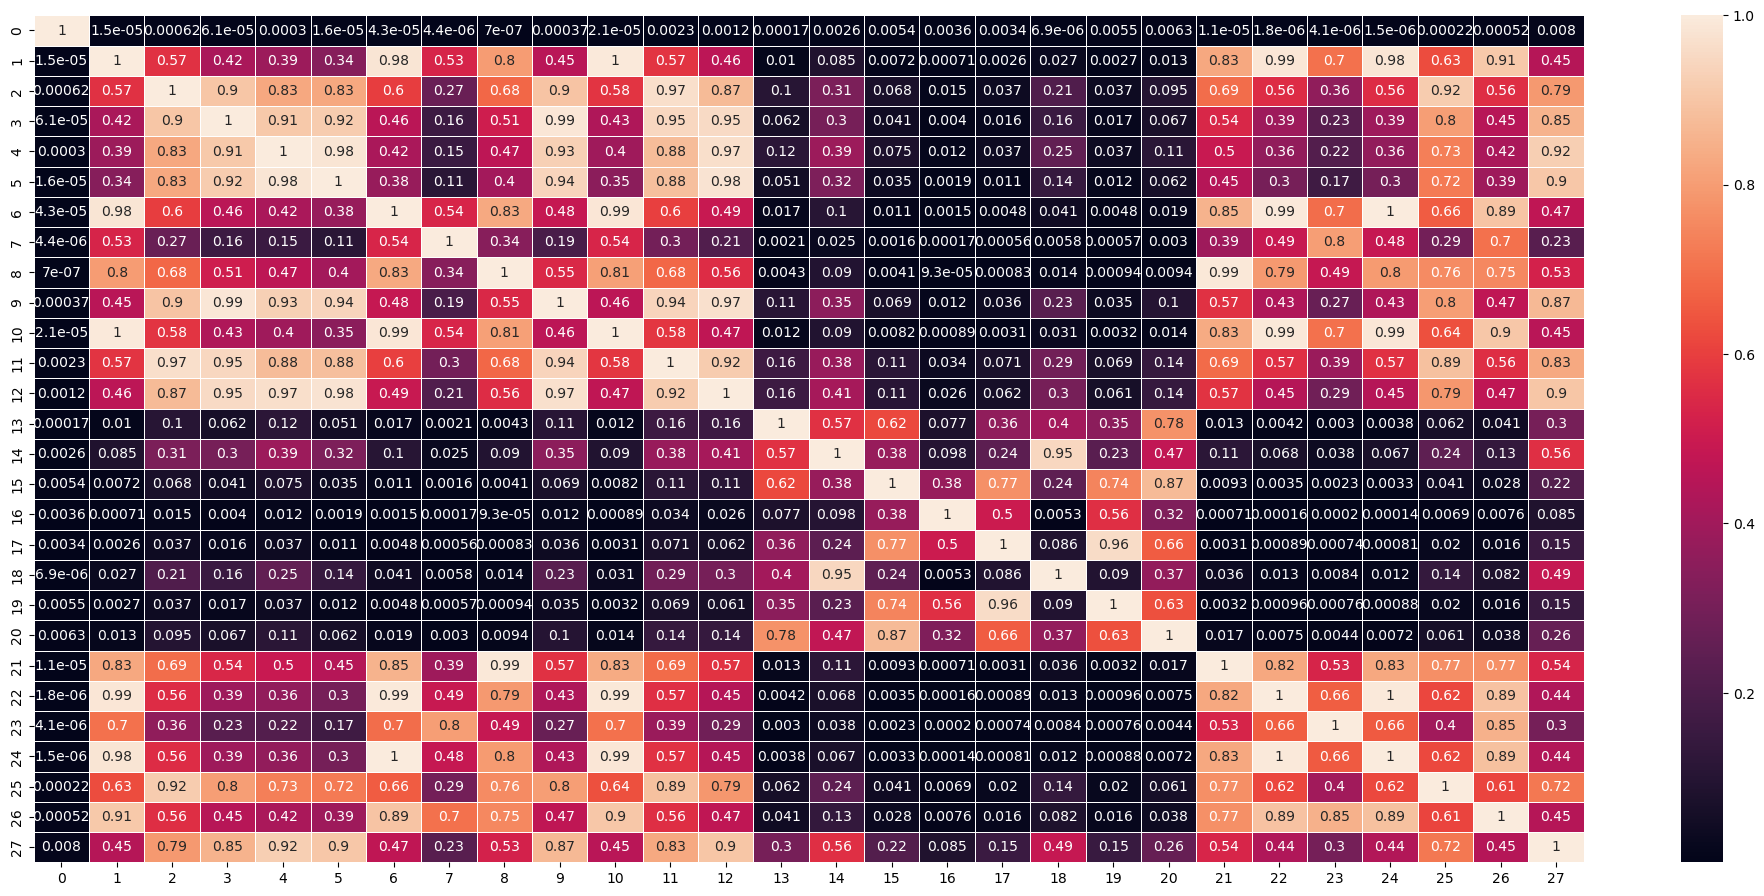

In [41]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "test", "system_accuracy", "max"))
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Test System Accuracy')
sns.boxplot(df_accuracy)

df_ttests = pd.DataFrame(check_all_ttest(df_accuracy))
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 11))
sns.heatmap(df_ttests, annot=True, linewidths=.5, ax=ax)

<Axes: xlabel='Run', ylabel='Val Classifier Coverage'>

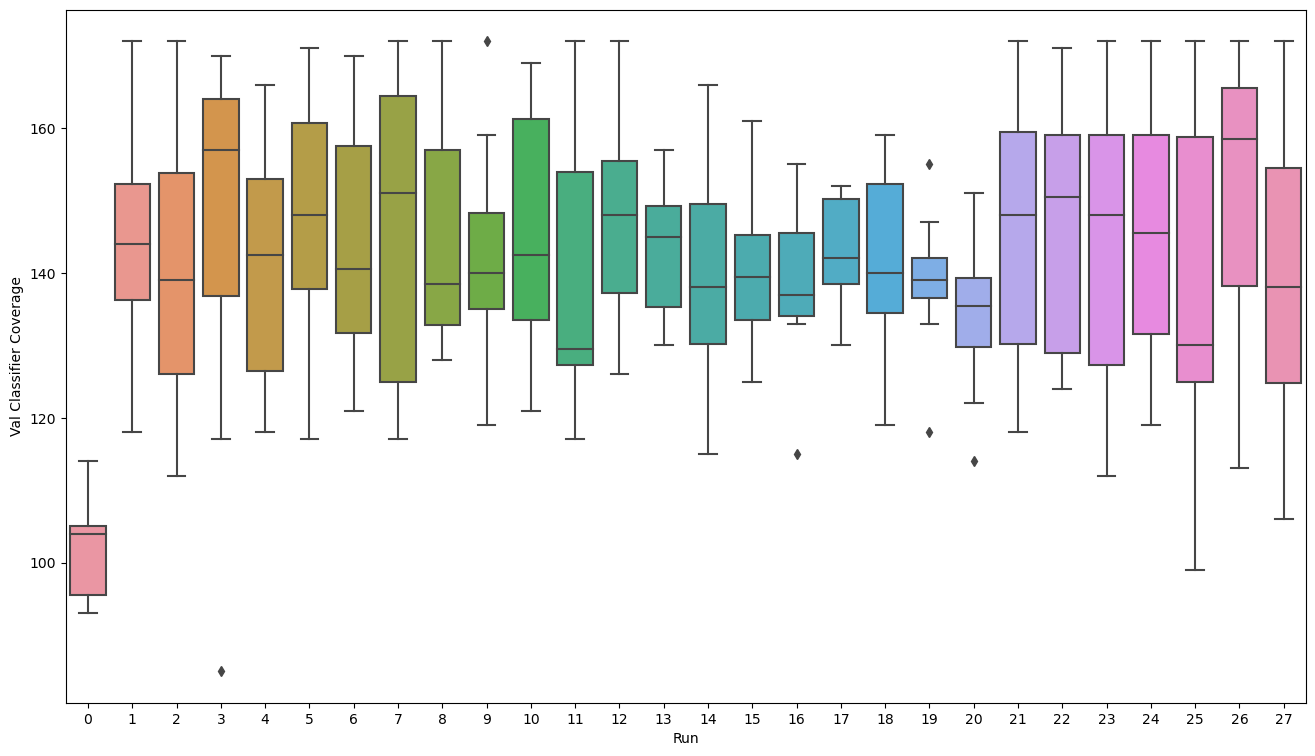

In [43]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "cov_classifier", "max"))
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Val Classifier Coverage')
sns.boxplot(df_accuracy)

<Axes: xlabel='Run', ylabel='Test Classifier Coverage'>

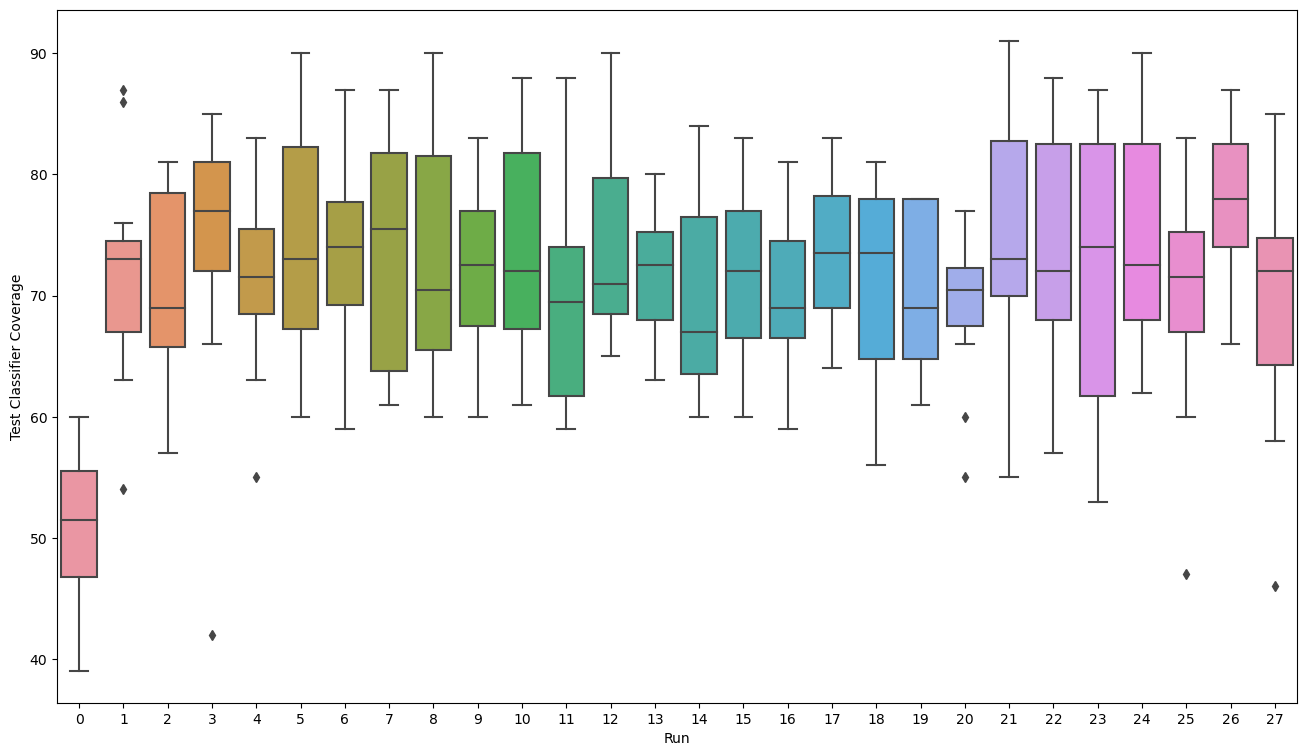

In [44]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "test", "cov_classifier", "max"))
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Test Classifier Coverage')
sns.boxplot(df_accuracy)

<Axes: xlabel='Run', ylabel='Val Classifier Accuracy'>

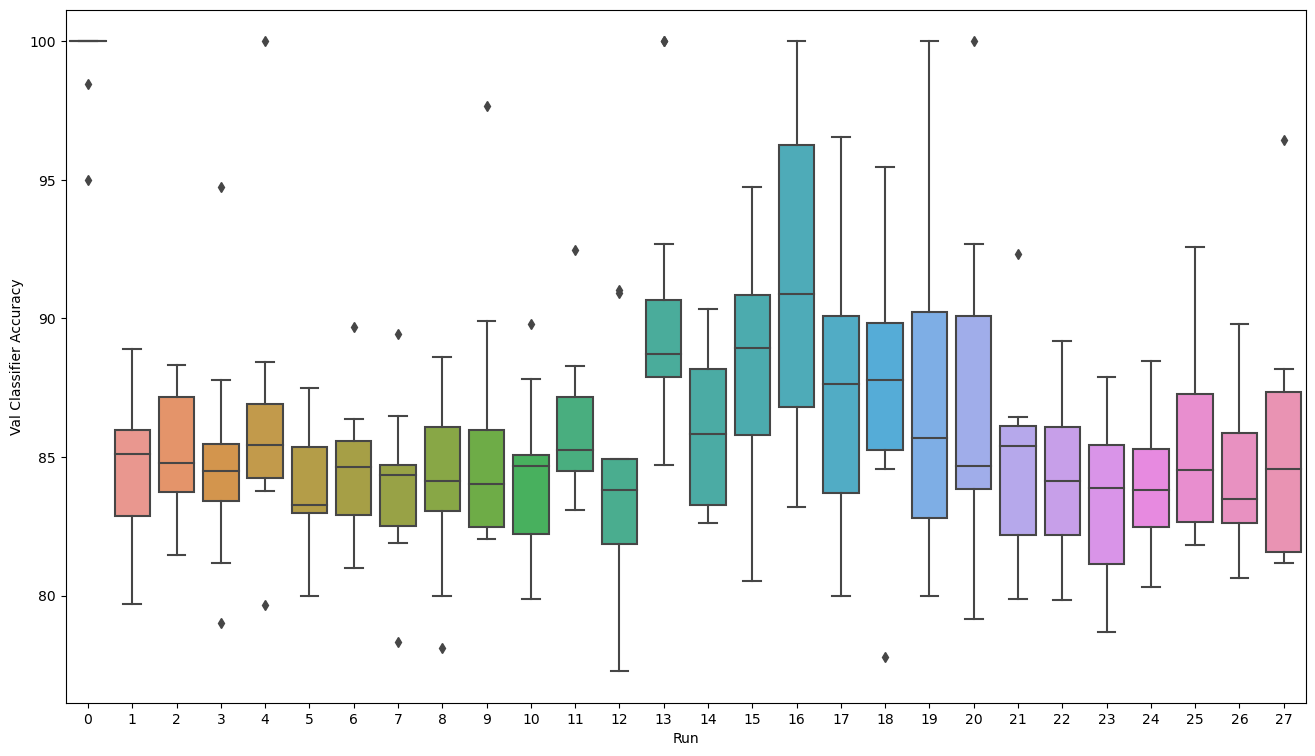

In [45]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "classifier_accuracy", "max"))
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Val Classifier Accuracy')
sns.boxplot(df_accuracy)

In [674]:
import math

expert_metrics = []
for run in values:
    temp1 = {
        4323195249: {},
        4295232296: {},
    }
    for column in run:
        temp1[4323195249][column] = [el[0] if isinstance(el, list) else None for el in run[column]]
        temp1[4295232296][column] = [el[0] if isinstance(el, list) else None for el in run[column]]
    expert_metrics.append(temp1)

In [700]:
pd.DataFrame(pd.DataFrame(expert_metrics)[4323195249])

,4323195249
0,"{'Seed_1_Fold_0': [47, 29, 23, 22, 21, 18, 23,..."
1,"{'Seed_1_Fold_0': [44, 13, 4, 15, 19, 34, 36, ..."
2,"{'Seed_1_Fold_0': [77, 64, 62, 46, 32, 44, 43,..."
3,"{'Seed_1_Fold_0': [78, 73, 75, 50, 33, 37, 41,..."
4,"{'Seed_1_Fold_0': [72, 17, 9, 8, 16, 26, 22, 1..."
5,"{'Seed_1_Fold_0': [83, 41, 16, 12, 17, 17, 24,..."
6,"{'Seed_1_Fold_0': [74, 20, 8, 7, 21, 16, 18, 2..."
7,"{'Seed_1_Fold_0': [124, 107, 88, 52, 44, 35, 4..."


In [673]:
df1 = pd.DataFrame(temp1[4323195249])

In [671]:
df11 = df1.fillna(df1.mean())
pd.DataFrame(df11.mean())

,0
Seed_1_Fold_0,24.115385
Seed_1_Fold_1,39.846154
Seed_1_Fold_2,37.923077
Seed_1_Fold_3,6.038462
Seed_2_Fold_0,21.500000
Seed_2_Fold_1,10.230769
Seed_2_Fold_2,23.576923
Seed_2_Fold_3,45.269231
Seed_3_Fold_0,32.269231
Seed_3_Fold_1,32.222222


In [648]:
pd.DataFrame(temp1[4323195249])

,Seed_1_Fold_0,Seed_1_Fold_1,Seed_1_Fold_2,Seed_1_Fold_3,Seed_2_Fold_0,Seed_2_Fold_1,Seed_2_Fold_2,Seed_2_Fold_3,Seed_3_Fold_0,Seed_3_Fold_1,Seed_3_Fold_2,Seed_3_Fold_3
0,47.0,98.0,41.0,6.0,16.0,21.0,14.0,57.0,24.0,60,94.0,75
1,29.0,52.0,23.0,0.0,4.0,0.0,8.0,79.0,23.0,33,92.0,113
2,23.0,20.0,28.0,0.0,6.0,1.0,5.0,66.0,33.0,15,59.0,76
3,22.0,19.0,36.0,0.0,10.0,1.0,13.0,37.0,39.0,17,51.0,53
4,21.0,30.0,27.0,1.0,12.0,9.0,19.0,40.0,28.0,12,42.0,30
5,18.0,29.0,44.0,2.0,25.0,12.0,22.0,39.0,30.0,17,40.0,25
6,23.0,43.0,33.0,7.0,22.0,5.0,20.0,35.0,17.0,31,29.0,47
7,15.0,33.0,32.0,7.0,21.0,11.0,26.0,39.0,26.0,28,60.0,35
8,22.0,36.0,27.0,8.0,17.0,9.0,35.0,31.0,29.0,32,45.0,56
9,15.0,40.0,34.0,7.0,19.0,10.0,29.0,41.0,37.0,32,40.0,56


In [607]:
values[0]

,Seed_1_Fold_0,Seed_1_Fold_1,Seed_1_Fold_2,Seed_1_Fold_3,Seed_2_Fold_0,Seed_2_Fold_1,Seed_2_Fold_2,Seed_2_Fold_3,Seed_3_Fold_0,Seed_3_Fold_1,Seed_3_Fold_2,Seed_3_Fold_3
0,"[47, 33]","[98, 4]","[41, 18]","[6, 49]","[16, 10]","[21, 23]","[14, 3]","[57, 1]","[24, 3]","[60, 65]","[94, 1]","[75, 16]"
1,"[29, 0]","[52, 0]","[23, 1]","[0, 14]","[4, 6]","[0, 0]","[8, 0]","[79, 0]","[23, 0]","[33, 65]","[92, 0]","[113, 3]"
2,"[23, 1]","[20, 0]","[28, 1]","[0, 11]","[6, 11]","[1, 0]","[5, 0]","[66, 0]","[33, 0]","[15, 76]","[59, 0]","[76, 7]"
3,"[22, 6]","[19, 1]","[36, 2]","[0, 12]","[10, 14]","[1, 0]","[13, 0]","[37, 0]","[39, 0]","[17, 65]","[51, 0]","[53, 17]"
4,"[21, 8]","[30, 1]","[27, 9]","[1, 24]","[12, 14]","[9, 0]","[19, 0]","[40, 0]","[28, 1]","[12, 57]","[42, 0]","[30, 17]"
5,"[18, 7]","[29, 6]","[44, 7]","[2, 19]","[25, 13]","[12, 3]","[22, 0]","[39, 0]","[30, 8]","[17, 37]","[40, 2]","[25, 12]"
6,"[23, 16]","[43, 11]","[33, 12]","[7, 22]","[22, 20]","[5, 4]","[20, 2]","[35, 0]","[17, 8]","[31, 45]","[29, 2]","[47, 26]"
7,"[15, 11]","[33, 10]","[32, 18]","[7, 30]","[21, 19]","[11, 1]","[26, 2]","[39, 0]","[26, 3]","[28, 44]","[60, 4]","[35, 27]"
8,"[22, 9]","[36, 2]","[27, 18]","[8, 21]","[17, 16]","[9, 1]","[35, 0]","[31, 0]","[29, 8]","[32, 39]","[45, 6]","[56, 16]"
9,"[15, 10]","[40, 9]","[34, 23]","[7, 24]","[19, 18]","[10, 3]","[29, 0]","[41, 0]","[37, 9]","[32, 48]","[40, 7]","[56, 16]"


In [ ]:
dict_run = {}
for run in range(len(metrics)):
    dict_seed = {}
    for seed, val1 in metrics[run]["verma"].items():
        dict_fold = {}
        for fold, element in metrics[run]["verma"][seed].items():
            dict_fold[f"Fold_{fold}"] = create_dataframe_one_metric(metrics, run, "verma", seed, fold, "val")
        df_seed = pd.concat(dict_fold)
        dict_seed[f"Seed_{seed}"] = df_seed
    df_run = pd.concat(dict_seed)
    dict_run[f"Run_{run}"] = df_run
pd.concat(dict_run)

## Experts

In [928]:
import matplotlib.pyplot as plt

def get_expert_values(step, metric_name):

    mett = []
    for element in metrics:
        met = {}
        for seed, value1 in element["expert metrics"].items():
            for fold, value2 in value1.items():
                for expert, value3 in value2.items():
                    if expert not in met:
                        met[expert] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"]["End"] = value3[step]["End"][metric_name]
                    if "Start" in value3[step]:
                        met[expert][f"Seed_{seed}_Fold_{fold}"]["Start"] = value3[step]["Start"][metric_name]
                    else:
                        pass
        mett.append(met)
    return mett

def get_single_values(met, run, expert_id, step):
    values = []
    for key, value in met[run][expert_id].items():
        values.append(value[step])
    return values

def plot_expert_values(met):
    df1 = pd.DataFrame(met[4323195249])
    df2 = pd.DataFrame(met[4295232296])

    fd1 = df1.T.reset_index()
    fd1["expert"] = 4323195249
    fd2 = df2.T.reset_index()
    fd2["expert"] = 4295232296
    df3 = pd.concat([fd1, fd2])
    df3 = df3.melt(id_vars=["index", "expert"])

    plt.figure()
    sns.boxplot(df3, x="expert", y="value",
            hue="variable",)

In [939]:
metrics[18]["expert metrics"]

{1: {0: {}, 1: {}, 2: {}, 3: {}},
 2: {0: {}, 1: {}, 2: {}, 3: {}},
 3: {0: {}, 1: {}, 2: {}, 3: {}}}

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,False
1,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,True
2,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,False
5,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,True
6,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,False
9,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,True


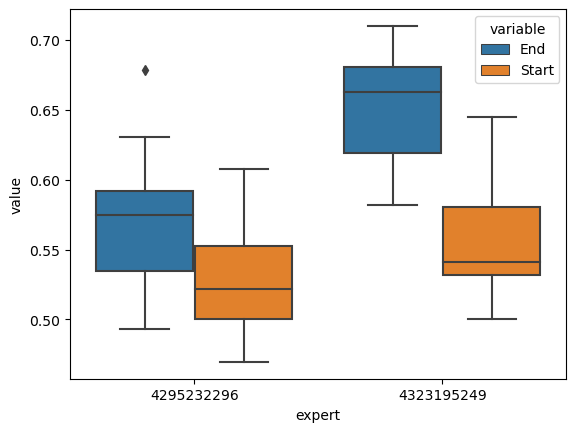

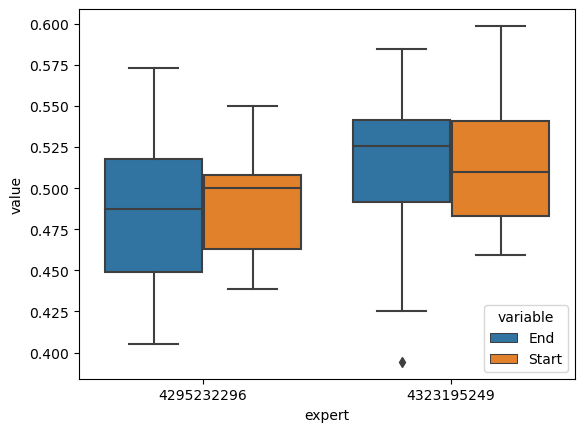

In [931]:
met = get_expert_values("Val", "accurancy_balanced")

plot_expert_values(met[2])
plot_expert_values(met[1])
df_runs

In [924]:
met = get_expert_values("Val", "accurancy_balanced")

for i in range(16):

    run = i
    expert = 4323195249

    if df_runs.iloc[i]["mod"] == "ssl":
        continue

    v1 = get_single_values(met, run, expert, "Start")
    v2 = get_single_values(met, run, expert, "End")

    res = get_ttest(v1, v2)
    if res.pvalue <= 0.05:
        print(f"run {run} with p {res.pvalue} for expert {expert}")

    expert = 4295232296

    v1 = get_single_values(met, run, expert, "Start")
    v2 = get_single_values(met, run, expert, "End")

    get_ttest(v1, v2)

    res = get_ttest(v1, v2)
    if res.pvalue <= 0.05:
        print(f"run {run} with p {res.pvalue} for expert {expert}")

run 2 with p 6.19540626091039e-05 for expert 4323195249
run 2 with p 0.0469923322181665 for expert 4295232296
run 3 with p 2.3361743556462247e-05 for expert 4323195249
run 6 with p 2.7435772736443634e-07 for expert 4323195249
run 6 with p 0.002706800088076692 for expert 4295232296
run 7 with p 9.589903316162385e-05 for expert 4323195249
run 7 with p 0.04598397568702153 for expert 4295232296
run 8 with p 0.04008895794698606 for expert 4295232296
run 9 with p 0.046552365375806426 for expert 4295232296
run 10 with p 1.195760722104384e-08 for expert 4323195249
run 10 with p 0.0003275446433969614 for expert 4295232296
run 11 with p 2.994233304825926e-05 for expert 4323195249
run 11 with p 0.017748579219644563 for expert 4295232296
run 14 with p 0.0013615223130475273 for expert 4295232296
run 15 with p 0.03854894882308851 for expert 4323195249


In [925]:
df_runs

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,False
1,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,True
2,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,False
5,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,True
6,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,False
9,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,True


In [51]:
def create_expert_metrics(met):
    metrics = {}
    for expert_id in met[0]:
        metrics[expert_id] = []
        for run in met:
            start_metrics = {}
            end_metrics = {}
            for seed_fold, value in run[expert_id].items():
                if "Start" in value:
                    start_metrics[seed_fold] = value["Start"]
                end_metrics[seed_fold] = value["End"]
            if len(start_metrics) == 0:
                start_metrics = end_metrics
            metrics[expert_id].append({
                "Start": start_metrics,
                "End": end_metrics
            })
    return metrics

def get_expert_df(metrics, expert_id, start=False):
    if start:
        df1 = pd.DataFrame([row["Start"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='start')
    df2 = pd.DataFrame([row["End"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='end')

    if start:
        df_final = df1
        df_final["end"] = df2["end"]
    else:
        df_final = df2
    df_final = df_final.melt(id_vars=["index", "seed_fold"], var_name="step")

    return df_final

def plot_expert_runs_al(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id, start=True)
    plt.figure()
    sns.boxplot(df, x="index", y="value", hue="step")

def plot_expert_runs_end(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id)
    plt.figure()
    sns.boxplot(df, x="index", y="value")

In [52]:
plot_expert_runs_al(metrics, 4323195249, "Val", "accurancy_balanced")

NameError: name 'get_expert_values' is not defined

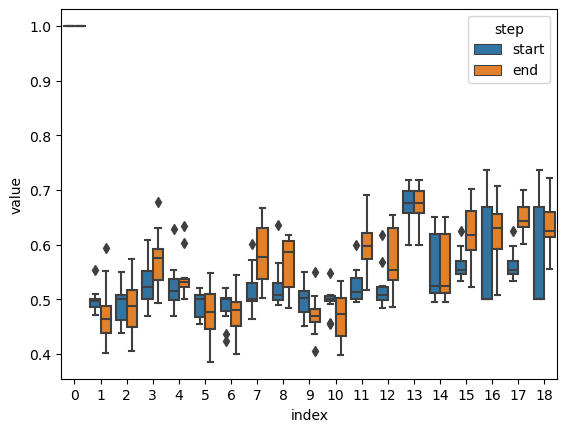

In [985]:
plot_expert_runs_al(metrics, 4295232296, "Val", "accurancy_balanced")

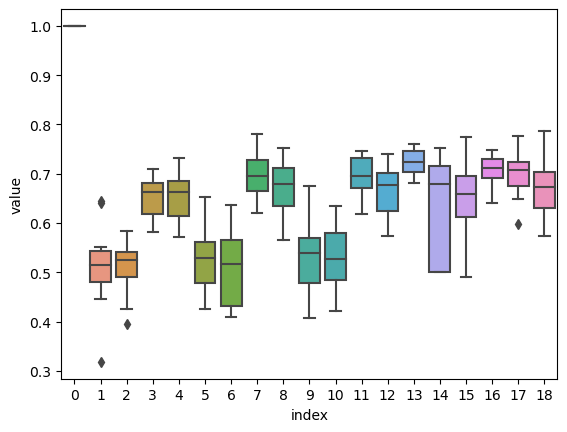

In [986]:
plot_expert_runs_end(metrics, 4323195249, "Val", "accurancy_balanced")

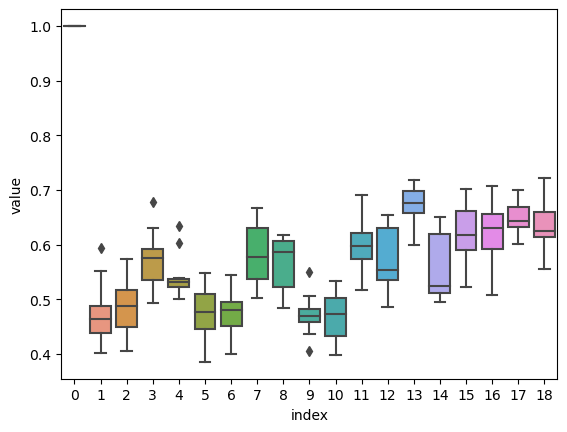

In [987]:
plot_expert_runs_end(metrics, 4295232296, "Val", "accurancy_balanced")

In [503]:
temp = pd.DataFrame(metrics[4323195249]).reset_index().melt('index', var_name='step',  value_name='vals')
temp["vals"]

0     {'Seed_1_Fold_0': 0.5714285714285714, 'Seed_1_...
1     {'Seed_1_Fold_0': 0.48376623376623373, 'Seed_1...
2     {'Seed_1_Fold_0': 0.5383141762452107, 'Seed_1_...
3     {'Seed_1_Fold_0': 0.5523627075351213, 'Seed_1_...
4     {'Seed_1_Fold_0': 0.5422077922077922, 'Seed_1_...
5     {'Seed_1_Fold_0': 0.5064935064935064, 'Seed_1_...
6     {'Seed_1_Fold_0': 0.5346956151553852, 'Seed_1_...
7     {'Seed_1_Fold_0': 0.5162337662337663, 'Seed_1_...
8     {'Seed_1_Fold_0': 0.4253246753246753, 'Seed_1_...
9     {'Seed_1_Fold_0': 0.6215410813111962, 'Seed_1_...
10    {'Seed_1_Fold_0': 0.6700723712217964, 'Seed_1_...
11    {'Seed_1_Fold_0': 0.6331168831168831, 'Seed_1_...
12    {'Seed_1_Fold_0': 0.6233766233766234, 'Seed_1_...
13    {'Seed_1_Fold_0': 0.6875266070668369, 'Seed_1_...
Name: vals, dtype: object

In [ ]:
.melt(var_name='Expert', value_name='values')